Paper: ImageNet classification with deep convolutional neural networks

    "https://dl.acm.org/doi/10.1145/3065386"

* This Code is based on the original AlexNet paper. I used the number of kernels same as the original paper although in the paper they stated that they trained it on 2 GPUs while this code will run on single GPU.
* Latest code is available on pytorch models hub:
    "https://github.com/pytorch/vision/blob/main/torchvision/models/alexnet.py"

* Alex Krizhevsky updated model arguments for single GPU. It will be found on his github:
    "https://github.com/akrizhevsky/cuda-convnet2/blob/master/layers/layers-imagenet-1gpu.cfg"

In [1]:
import torch
import torch.nn as nn
from torchsummary import summary

import torchvision
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
transform_train = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear = 10, scale = (0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

In [3]:
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [4]:
train_ds = datasets.CIFAR10(
    root = './data',
    train = True,
    transform = None,
    download = True
)
test_dataset = datasets.CIFAR10(
    root = './data',
    train = False,
    transform = transform,
    download = True
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
val_size = 5000
train_size = len(train_ds) - val_size
train_size, val_size

(45000, 5000)

In [6]:
train_dataset, val_dataset = random_split(train_ds, [train_size, val_size])
len(train_dataset), len(val_dataset)

(45000, 5000)

In [7]:
train_dataset = MyDataset(train_dataset, transform = transform_train)
val_dataset = MyDataset(val_dataset, transform = transform_train)
len(train_dataset), len(val_dataset)

(45000, 5000)

In [8]:
BATCH_SIZE = 4
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, pin_memory = True)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, pin_memory = True)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS, pin_memory = True)

In [9]:
class_names = test_dataset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

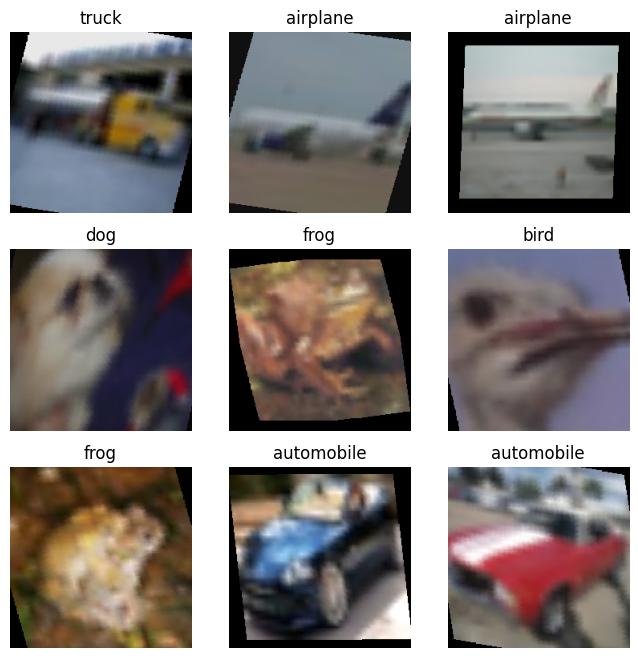

In [10]:
figure = plt.figure(figsize = (8, 8))
row, col = 3, 3
for i in range(1, row * col + 1):
    random_idx = torch.randint(len(train_dataset), size = (1,)).item()
    img, label = train_dataset[random_idx]
    img = img / 2 + 0.5
    figure.add_subplot(row, col, i)
    plt.title(class_names[label])
    plt.axis('off')
    plt.imshow(img.permute(1, 2, 0))
plt.show()

In [11]:
class AlexNet(nn.Module):
    def __init__(self, image_channels, num_classes):
        super().__init__()
        self.image_channels = image_channels
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(image_channels, 96, kernel_size = 11, stride = 4, padding = 0)
        self.relu = nn.ReLU()
        self.lrn = nn.LocalResponseNorm(5, k = 2)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2)
        self.conv2 = nn.Conv2d(96, 256, kernel_size = 5, stride = 1, padding = 2)
        self.conv3 = nn.Conv2d(256, 384, kernel_size = 3, stride = 1, padding = 1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size = 3, stride = 1, padding = 1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size = 3, stride = 1, padding = 1)
        self.dropout = nn.Dropout(p = 0.5)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.lrn(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.lrn(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [12]:
model = AlexNet(3, 10).to(device)

In [13]:
summary(model, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 0.0005)

In [15]:
print(len(train_dataloader.dataset))
print(len(train_dataloader))

45000
11250


In [16]:
epochs = 7
train_loss_log = []
train_accuracy_log = []
val_loss_log = []
val_accuracy_log = []
for epoch in range(epochs):
    train_size = len(train_dataloader.dataset)
    no_of_batches = len(train_dataloader)
    train_loss, train_correct = 0, 0
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = criterion(pred, y)
        train_loss += loss
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{train_size:>5d}]")

    train_loss /= no_of_batches
    train_correct /= train_size
    train_loss_log.append(train_loss)
    train_accuracy_log.append(train_correct)

    # validation
    val_loss, val_correct = 0, 0
    val_size = len(val_dataloader.dataset)
    no_of_val_batches = len(val_dataloader)
    model.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(val_dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = criterion(pred, y)
            val_loss += loss
            val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    val_loss /= no_of_val_batches
    val_correct /= val_size
    val_loss_log.append(val_loss)
    val_accuracy_log.append(val_correct)

    print(f"Epoch : {epoch + 1}")
    print(f"Average train loss : {train_loss:>8f}, Train accuracy : {(100 * train_correct):>0.2f}%")
    print(f"Average validation loss : {val_loss:>8f}, Validation accuracy : {(100 * val_correct):>0.2f}%")

loss: 2.302244  [    4/45000]
loss: 2.310164  [  404/45000]
loss: 2.296141  [  804/45000]
loss: 2.297508  [ 1204/45000]
loss: 2.316112  [ 1604/45000]
loss: 2.303874  [ 2004/45000]
loss: 2.296960  [ 2404/45000]
loss: 2.287467  [ 2804/45000]
loss: 2.298292  [ 3204/45000]
loss: 2.297382  [ 3604/45000]
loss: 2.315614  [ 4004/45000]
loss: 2.261419  [ 4404/45000]
loss: 2.284999  [ 4804/45000]
loss: 2.288650  [ 5204/45000]
loss: 2.296878  [ 5604/45000]
loss: 2.284675  [ 6004/45000]
loss: 2.274225  [ 6404/45000]
loss: 2.271664  [ 6804/45000]
loss: 2.288809  [ 7204/45000]
loss: 2.288583  [ 7604/45000]
loss: 2.309618  [ 8004/45000]
loss: 2.277460  [ 8404/45000]
loss: 2.297606  [ 8804/45000]
loss: 2.243489  [ 9204/45000]
loss: 2.278582  [ 9604/45000]
loss: 2.552291  [10004/45000]
loss: 1.970072  [10404/45000]
loss: 2.388946  [10804/45000]
loss: 2.009750  [11204/45000]
loss: 2.012654  [11604/45000]
loss: 1.993915  [12004/45000]
loss: 2.003341  [12404/45000]
loss: 2.362768  [12804/45000]
loss: 1.78

In [17]:
model.eval()
test_size = len(test_dataloader.dataset)
no_of_test_batches = len(test_dataloader)
test_loss, test_correct = 0, 0
with torch.no_grad():
    for batch, (X, y) in enumerate(test_dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = criterion(pred, y)
        test_loss += loss
        test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
test_loss /= no_of_test_batches
test_correct /= test_size
print(f"Average test loss : {test_loss:>8f}, Test accuracy : {(100 * test_correct):>0.2f}%")

Average test loss : 0.709746, Test accuracy : 75.84%


In [18]:
train_loss_log = [i.cpu() for i in train_loss_log]
train_loss_log

[tensor(1.8842, grad_fn=<ToCopyBackward0>),
 tensor(1.3456, grad_fn=<ToCopyBackward0>),
 tensor(1.0871, grad_fn=<ToCopyBackward0>),
 tensor(0.9445, grad_fn=<ToCopyBackward0>),
 tensor(0.8575, grad_fn=<ToCopyBackward0>),
 tensor(0.7938, grad_fn=<ToCopyBackward0>),
 tensor(0.7399, grad_fn=<ToCopyBackward0>)]

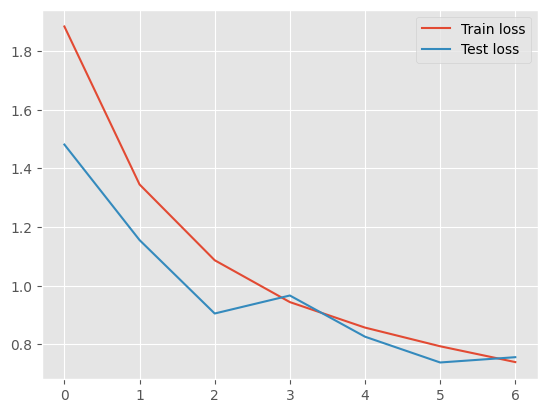

In [19]:
plt.style.use('ggplot')
plt.plot([i.cpu().detach().numpy() for i in train_loss_log], label = "Train loss")
plt.plot([i.cpu().detach().numpy() for i in val_loss_log], label = "Test loss")
plt.legend()

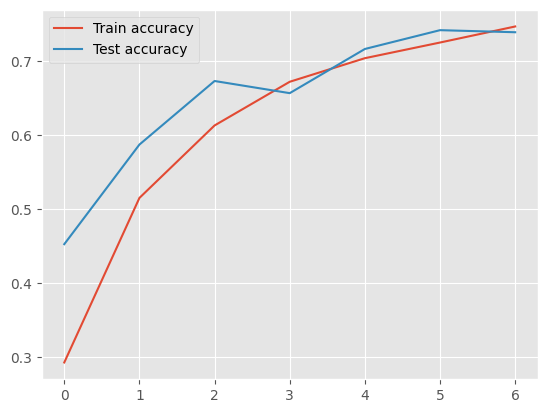

In [20]:
plt.style.use('ggplot')
plt.plot(train_accuracy_log, label = "Train accuracy")
plt.plot(val_accuracy_log, label = "Test accuracy")
plt.legend()

We can see that there is an overfitting problem in this model. This can be reduced in various ways.
Now, let's try this dataset on pytorch AlexNet, using transfer learning

In [21]:
BATCH_SIZE = 4
NUM_WORKERS = os.cpu_count()

train_dataloader1 = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, pin_memory = True)
val_dataloader1 = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, pin_memory = True)
test_dataloader1 = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = NUM_WORKERS, pin_memory = True)

In [22]:
pretrained_model = torch.hub.load('pytorch/vision', 'alexnet', pretrained = True).to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
summary(pretrained_model, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]          23,296
              ReLU-2           [-1, 64, 56, 56]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [24]:
pretrained_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(pretrained_model.parameters(), lr = 0.001, momentum = 0.9)

In [26]:
epochs = 7
train_loss_log1 = []
train_accuracy_log1 = []
val_loss_log1 = []
val_accuracy_log1 = []
for epoch in range(epochs):
    train_size = len(train_dataloader1.dataset)
    no_of_batches = len(train_dataloader1)
    train_loss, train_correct = 0, 0
    pretrained_model.train()
    for batch, (X, y) in enumerate(train_dataloader1):
        X, y = X.to(device), y.to(device)
        pred = pretrained_model(X)
        loss = criterion(pred, y)
        train_loss += loss
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{train_size:>5d}]")

    train_loss /= no_of_batches
    train_correct /= train_size
    train_loss_log1.append(train_loss)
    train_accuracy_log1.append(train_correct)

    # validation
    val_loss, val_correct = 0, 0
    val_size = len(val_dataloader1.dataset)
    no_of_val_batches = len(val_dataloader1)
    pretrained_model.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(val_dataloader1):
            X, y = X.to(device), y.to(device)
            pred = pretrained_model(X)
            loss = criterion(pred, y)
            val_loss += loss
            val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    val_loss /= no_of_val_batches
    val_correct /= val_size
    val_loss_log1.append(val_loss)
    val_accuracy_log1.append(val_correct)

    print(f"Epoch : {epoch + 1}")
    print(f"Average train loss : {train_loss:>8f}, Train accuracy : {(100 * train_correct):>0.2f}%")
    print(f"Average validation loss : {val_loss:>8f}, Validation accuracy : {(100 * val_correct):>0.2f}%")

loss: 8.704583  [    4/45000]
loss: 2.489769  [  404/45000]
loss: 1.420904  [  804/45000]
loss: 2.266413  [ 1204/45000]
loss: 1.021696  [ 1604/45000]
loss: 0.989981  [ 2004/45000]
loss: 3.041180  [ 2404/45000]
loss: 1.564279  [ 2804/45000]
loss: 2.952255  [ 3204/45000]
loss: 1.300358  [ 3604/45000]
loss: 2.319525  [ 4004/45000]
loss: 2.641250  [ 4404/45000]
loss: 1.777684  [ 4804/45000]
loss: 1.428996  [ 5204/45000]
loss: 1.644057  [ 5604/45000]
loss: 1.296795  [ 6004/45000]
loss: 1.469303  [ 6404/45000]
loss: 2.132361  [ 6804/45000]
loss: 1.364624  [ 7204/45000]
loss: 3.000429  [ 7604/45000]
loss: 1.992510  [ 8004/45000]
loss: 1.475337  [ 8404/45000]
loss: 0.698876  [ 8804/45000]
loss: 1.144144  [ 9204/45000]
loss: 0.957900  [ 9604/45000]
loss: 1.764773  [10004/45000]
loss: 1.544936  [10404/45000]
loss: 1.212268  [10804/45000]
loss: 1.141368  [11204/45000]
loss: 1.118597  [11604/45000]
loss: 1.147246  [12004/45000]
loss: 0.803233  [12404/45000]
loss: 0.348204  [12804/45000]
loss: 1.30

In [27]:
pretrained_model.eval()
test_size = len(test_dataloader1.dataset)
no_of_test_batches = len(test_dataloader1)
test_loss, test_correct = 0, 0
with torch.no_grad():
    for batch, (X, y) in enumerate(test_dataloader1):
        X, y = X.to(device), y.to(device)
        pred = pretrained_model(X)
        loss = criterion(pred, y)
        test_loss += loss
        test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
test_loss /= no_of_test_batches
test_correct /= test_size
print(f"Average test loss : {test_loss:>8f}, Test accuracy : {(100 * test_correct):>0.2f}%")

Average test loss : 0.525377, Test accuracy : 82.87%


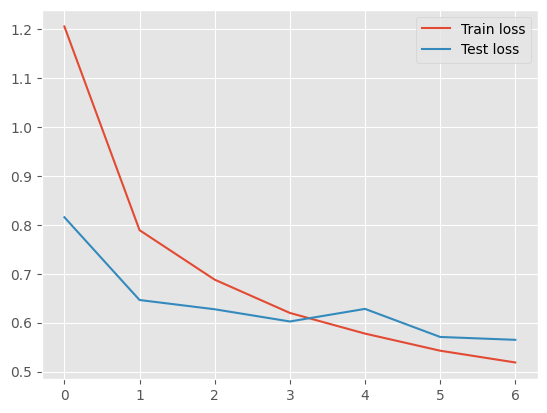

In [28]:
plt.style.use('ggplot')
plt.plot([i.cpu().detach().numpy() for i in train_loss_log1], label = "Train loss")
plt.plot([i.cpu().detach().numpy() for i in val_loss_log1], label = "Test loss")
plt.legend()

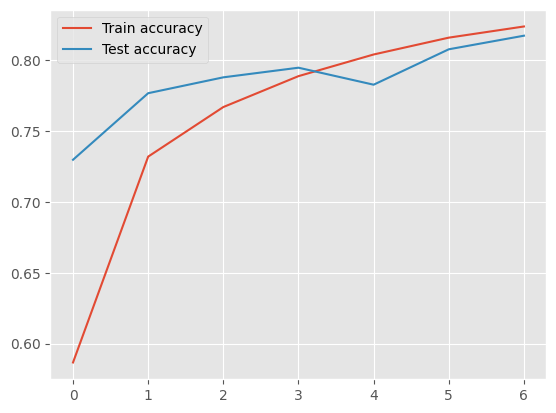

In [29]:
plt.style.use('ggplot')
plt.plot(train_accuracy_log1, label = "Train accuracy")
plt.plot(val_accuracy_log1, label = "Test accuracy")
plt.legend()

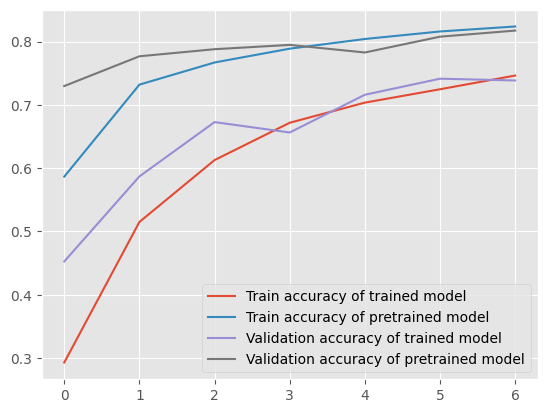

In [75]:
plt.style.use('ggplot')
plt.plot(train_accuracy_log, label = "Train accuracy of trained model")
plt.plot(train_accuracy_log1, label = "Train accuracy of pretrained model")
plt.plot(val_accuracy_log, label = "Validation accuracy of trained model")
plt.plot(val_accuracy_log1, label = "Validation accuracy of pretrained model")
plt.legend()

In [71]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [72]:
# helper functions
import torch.nn.functional as F
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    images = images.to(device)
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            class_names[preds[idx]],
            probs[idx] * 100.0,
            class_names[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [73]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

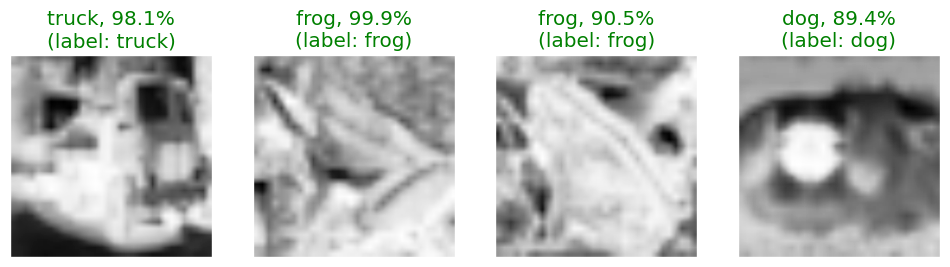

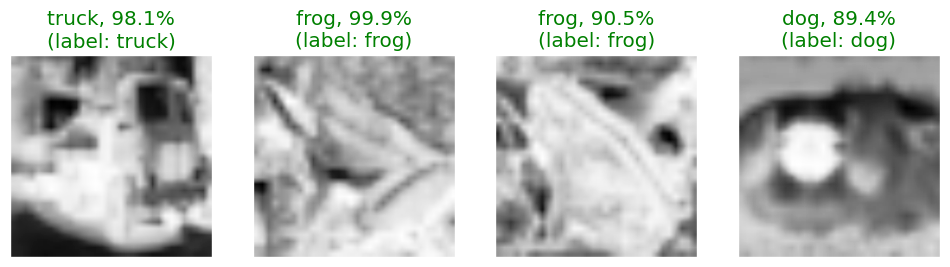

In [74]:
plot_classes_preds(model, images, labels)
# Both row shows the same example. This needs to be fixed.